In [1]:
# libraries
import numpy as np
import quandl
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [70]:
data = quandl.get("WIKI/AAPL")
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.422706,0.424470,0.422706,0.422706,117258400.0
1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.402563,0.402563,0.400652,0.400652,43971200.0
1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.373010,0.373010,0.371246,0.371246,26432000.0
1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.380362,0.382273,0.380362,0.380362,21610400.0
1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.391536,0.393300,0.391536,0.391536,18362400.0


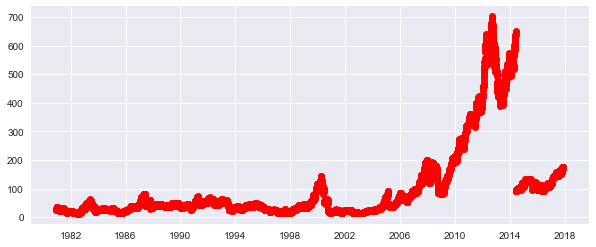

In [71]:
# plotting
plt.figure(figsize=(10,4))
plt.grid(True)
plt.plot(data['Open'],"ro")
plt.show()

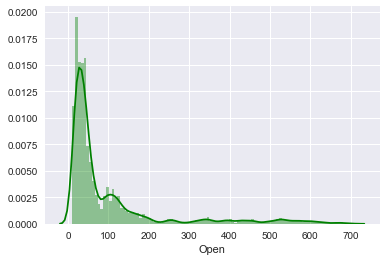

In [72]:
sns.distplot(data['Open'],bins=100,color="green")

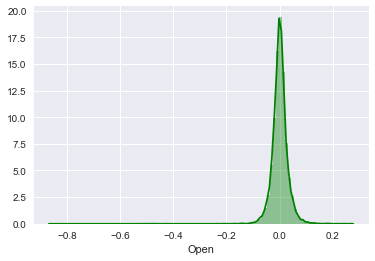

In [73]:
sns.distplot(data['Open'].pct_change().dropna(),bins=100,color="green")

In [250]:
# simulation function
def stock_simulator(starting_price,periods,mean,std):
    X_axis = []
    Y_axis = []
    
    current_period = 1
    previous_price = starting_price
    
    while current_period <= periods:
        
        drift = float(mean)/periods
        shock = np.random.normal(loc=drift,scale=float(std)/np.sqrt(periods))
        
        current_price = previous_price + previous_price*(drift + shock)
        previous_price = current_price
        
        X_axis.append(current_period)
        Y_axis.append(current_price)
        
        current_period = current_period + 1
    
    plt.subplot(121)
    plt.plot(X_axis,Y_axis)
    return Y_axis[-1]

In [151]:
# simulation inputs
starting_price = data["Open"][-1]
periods = 365
mean = data["Open"].pct_change().dropna().mean()
std = data["Open"].pct_change().dropna().std()

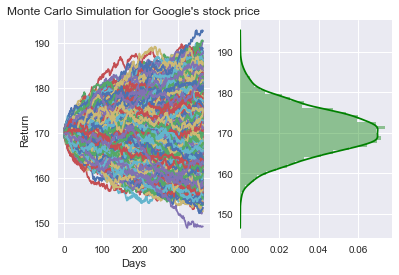

In [255]:
# simulation itself
simulations=0
outcomes = []
while simulations < 10000:
    outcomes.append(stock_simulator(starting_price,periods,mean,std))
    simulations += 1
    
plt.ylabel('Return')
plt.xlabel('Days')
plt.title("Monte Carlo Simulation for Google's stock price")
plt.subplot(122)
sns.distplot(outcomes,bins=50,color="green",vertical=True)

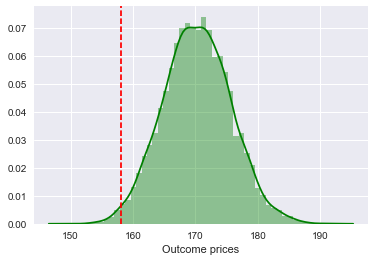

In [256]:
q = np.percentile(outcomes,1)
sns.distplot(outcomes,color="green",vertical=False,axlabel='Outcome prices')
plt.axvline(q, color="red", linestyle="--")

In [257]:
VaR_coef = (starting_price - q)/starting_price
investment = 5000
VaR = VaR_coef*investment
print(VaR)

350.631119022


In [254]:
print(VaR)

354.248561997
